In [2]:
import pandas as pd
import numpy as np
import sklearn
import graphviz
import os

import matplotlib 
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score

from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
import time
from operator import itemgetter

import xgboost as xgb

from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import sklearn
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


/Users/ppx/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#path_import = "/Users/ppx/Desktop/"
#import_file = "the_result_file.csv"
path = 'SMSSpamCollection.data'

In [4]:
GNB = GaussianNB()

DTC = tree.DecisionTreeClassifier()

ID3 = tree.DecisionTreeClassifier(criterion="entropy")

decision_stump = GradientBoostingClassifier(n_estimators=100,
                                 learning_rate=1.0,
                                 max_depth=1,
                                 random_state=0)

MLP = MLPClassifier(solver='lbfgs',
                    alpha=1,
                    hidden_layer_sizes=(20, 10))

KNN = KNeighborsClassifier()

BC = BaggingClassifier(n_estimators=50)

ABC = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1.0,
                         algorithm='SAMME.R',
                         random_state=None)

RFC = RandomForestClassifier(n_estimators=10,
                             criterion='gini',
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=1,
                             random_state=None,
                             verbose=0,
                             warm_start=False,
                             class_weight=None)




max_depth=7
learning_rate=0.05
n_estimators=50
gamma=0.5
reg_alpha=0.1


GBM = xgb.XGBClassifier(max_depth = max_depth, 
                        n_estimators = n_estimators, 
                        learning_rate = learning_rate,
                        gamma = gamma,
                        reg_alpha= reg_alpha)


In [5]:
colnames = ['Accuracy', 'AUC', 'Moyenne CV', 'Std CV','precision', 'Temps']
algos = [GNB, KNN, DTC, ID3, BC, RFC, ABC, decision_stump, GBM]
indexs = ['GNB', 'KNN', 'DTC', 'id3', 'BC', 'RFC', 'ABC', 'DS','GBM']
clfs = dict()
for x in range(len(algos)):
    clfs[indexs[x]] = algos[x]

modes = [None, 'normalized', 'min_max_ed', 'pca']

# Mise en forme donnée

In [6]:
data = pd.read_csv(path, delimiter='	',header=None, na_values='?')

In [7]:
mf = 500
vectorizer = CountVectorizer(max_features=mf)
X = vectorizer.fit_transform(data[1])
analyze = vectorizer.build_analyzer()
X = X.toarray()
X = pd.DataFrame(X)

In [8]:
target = pd.DataFrame(data[0])
target = target.replace('spam', 1)
target = target.replace('ham', 0)


# Qualité Apprentissage

In [9]:
class Qualite:
    def __init__(self, _modele, _data, _y, _y_pred, _y_pred_proba, _cv=10, _print_mode=True):
        
        self.accuracy = sklearn.metrics.accuracy_score(_y, _y_pred)
        self.AUC = sklearn.metrics.roc_auc_score(_y, _y_pred)
        self.cross_validation = cross_val_score(_modele, _data, y=_y, cv=_cv)
        self.moyenne = np.mean(self.cross_validation)
        self.ecart_type = np.std(self.cross_validation)
        self.precision = average_precision_score(_y, _y_pred)
        
        self.roc = ROC_curves(pred=_y_pred_proba, res=_y)
        
        
        if _print_mode:
            self.roc.plot_it()

# ROC

In [10]:
def TP(theta, pred, result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] > theta and x == 1:
            count += 1
        i += 1
    return count


def FP(theta, pred, result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] >= theta and x == 0:
            count += 1
        i += 1
    return count


def TN(theta, pred, result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] < theta and x == 0:
            count += 1
        i += 1
    return count


def FN(theta, pred, result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] < theta and x == 1:
            count += 1
        i += 1
    return count


class ROC_curves:
    def __init__(self, pred, res, gran = 101):
        x = []
        y = []
        for j in range(0,gran):
            tn = TN(j/(gran-1),pred,res)
            neg = tn + FP(j/(gran-1),pred,res)
            tp = TP(j/(gran-1),pred,res)
            pos = tp + FN(j/(gran-1),pred,res)

            if neg == 0:
                x.append(0)
            else:
                x.append(tn / neg)
            if pos == 0:
                y.append(0)
            else:
                y.append(tp / pos)
      
        self.rocx = x
        self.rocy = y
    def plot_it(self):
        plt.plot(self.rocx,self.rocy)
        plt.show()

# Apprentissage

In [11]:
def algo_apprentissage(mod, data, target, print_mode=True, cv=10):
    
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42)
    result = dict()
    mod_fit = mod.fit(X_train, y_train)
    y_prediction_proba = mod_fit.predict_proba(X_test)
    y_prediction = mod_fit.predict(X_test)
    q_mod = Qualite(_modele=mod,
                 _data=X_test,
                 _y=y_test,
                 _y_pred=y_prediction,
                 _y_pred_proba=y_prediction_proba,
                 _print_mode=print_mode,
                 _cv=cv)
    
    result['y_prediction_proba'] = y_prediction_proba
    result['y_prediction'] = y_prediction
    result['q_mod'] = q_mod
    
    if print_mode:
        print('La précision est ' + str(q_mod.accuracy))
        print('')
        print('L\'AUC est ' + str(q_mod.AUC))
        print('')
        print('Le score moyen par ' + str(cv) + ' cross-validation est ' + str(q_mod.moyenne))
    
    return result

# Parametres XGOOST

In [12]:
def param_XGB(data,
              target,
              max_depths=[10,50,100],
              learning_rates=[0.1,0.01],
              n_estimatorss=[50,100],
              sound_alarm=True):
    gamma=0.5
    reg_alpha=0.1
    colonnes = ['max_depth', 'learning_rates', 'n_estimators', 'score_moyen', 'qualite']
    result = pd.DataFrame(columns=colonnes)
    
    for md in max_depths:
        for lr in learning_rates:
            for ne in n_estimatorss:
                GBM = xgb.XGBClassifier(max_depth = md, 
                        n_estimators = ne, 
                        learning_rate = lr,
                        gamma = gamma,
                        reg_alpha= reg_alpha)
                apprentissage = algo_apprentissage(mod=GBM, data=data, target=target, print_mode=False)
                event = pd.DataFrame([[md, lr, ne, apprentissage['q_mod'].moyenne, apprentissage['q_mod']]], columns=colonnes)
                result = result.append(event)
                
    if sound_alarm:
        os.system('say "done"')
        
    result = result.reset_index()
    return result

# Attention, cette fonction mets du temps
#table_param = param_XGB(data=X, target=target)

# Transformation PCA

In [13]:
def pca_transform(data, target, variance=0.7, print_mode=True, normalized=True, min_max_ed=False):
    if normalized:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    elif min_max_ed:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
        
        
    for x in range(len(data[0])):
        pca = PCA(n_components=x)
        pca.fit(data)
        if sum(pca.explained_variance_ratio_) > variance:## and x >1:
            if print_mode:
                print('Hello World')
            break
    X_pca = pca.fit_transform(data)
    if print_mode:
        plt.scatter(X_pca[:, 0], X_pca[:, 1])
        plt.show()
        plt.close()
    return [pca, X_pca]
        
        
#pca_data = pca_transform(data=data['cleaned_data'], target=data['target'], normalized=True, print_mode=False)




In [14]:
def plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cvalidation=None,
                        n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5), print_mode=True):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cvalidation : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cvalidation, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    if print_mode:
        plt.show()
        plt.close()
    return plt


title = "Learning Curves"
cvalidation = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = KNN
# plot_learning_curve(estimator, title, X=data['cleaned_data'], y=data['target'], ylim=(0.4, 1.01), cvalidation=cvalidation, n_jobs=4)




In [15]:
def final_table(data,
                target,
                col=colnames,
                algos=algos,
                indexs=indexs,
                mode=None,
               print_mode=True):
    if mode is None:
        pass
    elif mode == 'normalized':
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    elif mode == 'min_max_ed':
        scaler = MinMaxScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    elif mode == 'pca':
        data = pca_transform(data=data,
                             target=target,
                                 normalized=True,
                                 print_mode=False)[1]


    result = []
    for alg in algos:
        t1 = time.time()
        res_algo = algo_apprentissage(alg, data=data, target=target, print_mode=print_mode)
        t2 = time.time()
        delta_t = t2 - t1
        ajout = [res_algo['q_mod'].accuracy, 
                 res_algo['q_mod'].AUC, 
                 res_algo['q_mod'].moyenne, 
                 res_algo['q_mod'].ecart_type, 
                 res_algo['q_mod'].precision,
                 delta_t]
        result.append(ajout)
        if print_mode:
            cvalidation = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
            plot_learning_curve(alg, 'str(alg)', X=data, y=target, ylim=(0.4, 1.01), cvalidation=cvalidation, n_jobs=4)



    result = pd.DataFrame(result, columns=colnames, index=indexs)
    return result



In [16]:
def comparisons_tables(data, target, modes=modes, print_mode=True):
    tables = dict()
    for mode in modes:
        event = dict()
        tables[str(mode)] = final_table(data=data, target=target, mode=mode, print_mode=print_mode)
    
    return tables

In [17]:
target.shape

(5572, 1)

In [18]:
target_bis = target.values.reshape(5572,)

In [19]:
# Attention, cela prend beaucoup de temps
final = final_table(X, target_bis, print_mode=False)

In [20]:
final


,Accuracy,AUC,Moyenne CV,Std CV,precision,Temps
GNB,0.684305,0.800777,0.844882,0.020545,0.286039,0.448131
KNN,0.938117,0.771294,0.892381,0.014901,0.597981,10.530830
DTC,0.966816,0.926925,0.955180,0.015438,0.783411,1.608374
id3,0.974888,0.940098,0.957866,0.015964,0.833095,1.062903
BC,0.972197,0.941383,0.958775,0.020389,0.816853,18.463195
RFC,0.982063,0.944238,0.965041,0.010878,0.880905,0.715995
ABC,0.973991,0.928228,0.956990,0.014833,0.827246,3.635398
DS,0.919283,0.820025,0.920221,0.021997,0.523708,5.461276
GBM,0.973991,0.916875,0.959692,0.016016,0.828184,14.590600


In [21]:
transformer = TfidfTransformer(smooth_idf=False)

In [22]:
tfidf = transformer.fit_transform(X)

In [ ]:
transformer = TfidfTransformer()
tfidf = pd.DataFrame(transformer.fit_transform(X).toarray())

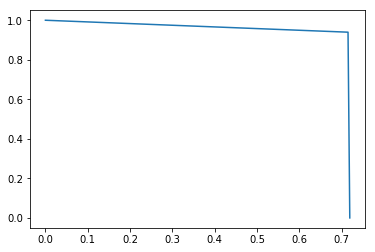

La précision est 0.745291479821

L'AUC est 0.827459113205

Le score moyen par 10 cross-validation est 0.842186878437


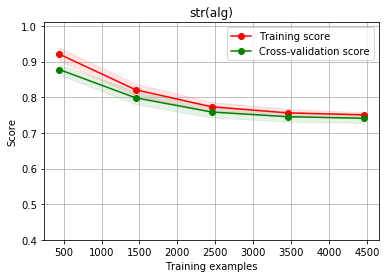

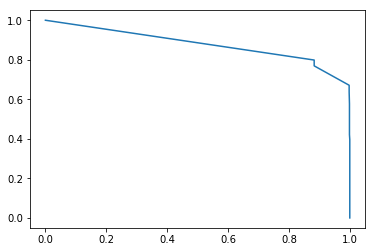

La précision est 0.942600896861

L'AUC est 0.788073005683

Le score moyen par 10 cross-validation est 0.880692786943


In [ ]:
final_tfidf = final_table(tfidf, target_bis, print_mode=False)
comparaison_tfidf = comparisons_tables(tfidf,target=target_bis)

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

In [ ]:
nc = 100

svd = TruncatedSVD(n_components=nc, n_iter=10, random_state=42)
svd.fit(tfidf) 
SVD = pd.DataFrame(svd.transform(tfidf))



In [ ]:
final_svd = final_table(SVD, target, print_mode=False)

In [ ]:
final_svd

Finalement on voit que faire les transformations proposées ne sont pas si performantes que cela.

Cela est surement du à la relative petite taille de notre jeu de données.

De plus cela est bien plus facilement interprétable.

